# Statistical Analyses

In [133]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [134]:
# Load DF
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/marketing-analytics-data/ifood_df.csv')
df.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [135]:
# Scale Income variable down by observing income in units of 1000.
df.insert(0, 'Income_1k', df['Income'] / 1000)
df.filter(like='Income').describe()

,Income_1k,Income
count,2205.000000,2205.000000
mean,51.622095,51622.094785
std,20.713064,20713.063826
min,1.730000,1730.000000
25%,35.196000,35196.000000
50%,51.287000,51287.000000
75%,68.281000,68281.000000
max,113.734000,113734.000000


## Linear Regression predicting Amounts Spent for each Category

We will perform regression analyses for each product category (MntX) individually and store the results in a single DataFrame.<br>
In order to ease interpretation, only the coefficients of the variables which are statistically significant will be included.<br>
Additionally, this DataFrame will also include the adjusted R² for each model.<br>

Finaly, to get an overview of the range of the coefficents, the DF will be displayed using a heatmap, replicating a visualization similar to MS Excel's conditional formatting.<br>

<b>NOTE</b>: The binary variables <i>marital_Single</i> and <i>education_Basic</i> will be excluded from the models. The information for both variable groups was originally stored in categorical variables, e.g. for education:<br>
Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4.<br>
In order to properly account for this in the regression models, the base categories (here: Single, basic education) must be removed.

In [136]:
# Define list of y variables to individually perform regression analyses on.
y_cols = ['MntWines',
          'MntFruits',
          'MntMeatProducts',
          'MntFishProducts',
          'MntSweetProducts',
          'MntGoldProds']

# Define X variables
X_remove = ['Income',
            'Z_CostContact',
            'Z_Revenue',
            'MntTotal',
            'MntRegularProds',
            'AcceptedCmpOverall',
            'marital_Single', 
            'education_Basic']

X_cols_all = [col for col in df.columns.to_list() if col not in X_remove]

# Create empty df to store results in
final = pd.DataFrame()
final.index = X_cols_all + ['Adj_R_squared']

# Run analysis for all defined dependent variables
for y_col in y_cols:
    # Define model variables
    y = df[y_col]
    X_cols = [col for col in X_cols_all if col != y_col]
    X = df.filter(X_cols)

    # Run regression model
    Xc = sm.add_constant(X)
    model = sm.OLS(y, Xc)
    result = model.fit()
    
    # Store temporary results and filter out only signficiant (p<0.05) parameters
    temp_res = pd.DataFrame()
    temp_res[y_col], temp_res['p_value'] = result.params, result.pvalues
    temp_res = temp_res.loc[temp_res['p_value'] <= 0.05, y_col]
    
    # Merge results to final df
    final = final.merge(temp_res, how='left', left_index=True, right_index=True)

    # include adj. R squared
    final[y_col]['Adj_R_squared'] = result.rsquared_adj

In [137]:
final

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Income_1k,5.618818,0.276685,3.240202,0.336733,0.416329,NaN
Kidhome,-48.338234,NaN,NaN,NaN,NaN,-10.062975
Teenhome,NaN,-3.220610,-71.558704,-9.169251,-3.812453,NaN
Recency,NaN,NaN,0.210157,NaN,NaN,NaN
MntWines,NaN,NaN,0.071146,NaN,-0.015484,NaN
MntFruits,NaN,NaN,0.500322,0.272458,0.207740,0.121690
MntMeatProducts,0.139620,0.027064,NaN,0.037164,0.014731,-0.019620
MntFishProducts,NaN,0.158976,0.400869,NaN,0.149219,0.140855
MntSweetProducts,-0.527560,0.195106,0.255756,0.240184,NaN,NaN
MntGoldProds,NaN,0.057056,-0.170054,0.113184,NaN,NaN


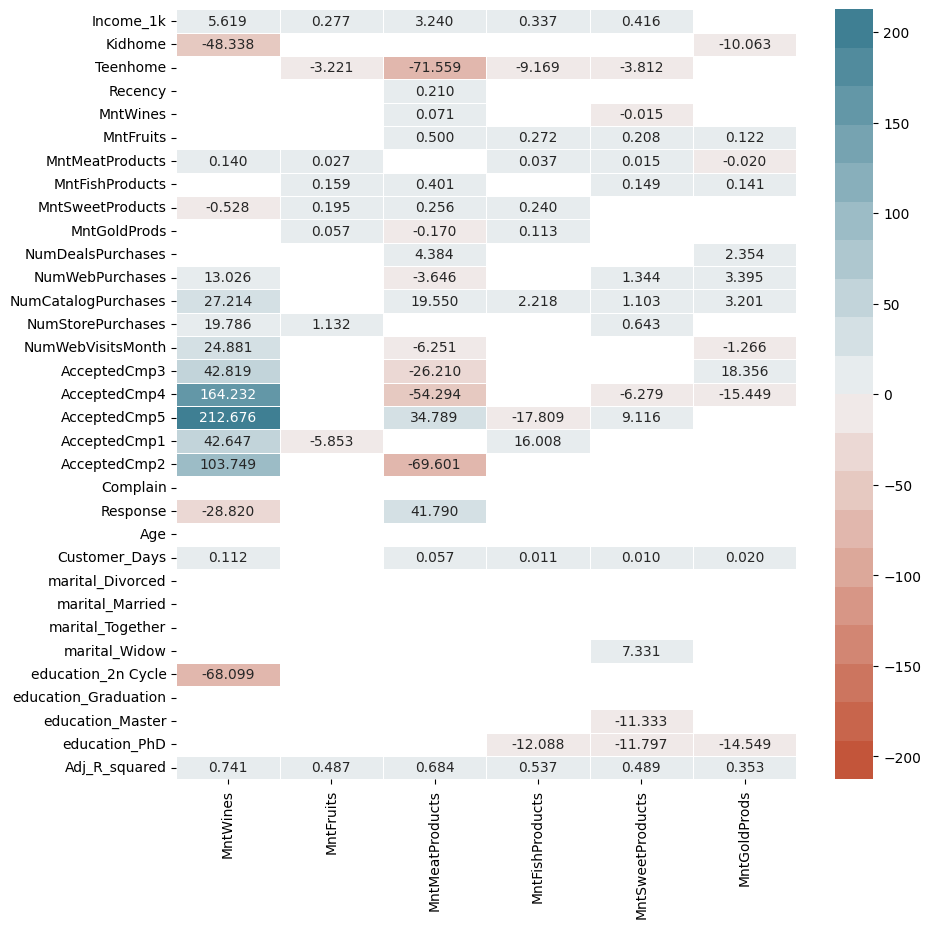

In [138]:
plt.figure(figsize=(10,10))
v = abs(final).max().max()
sns.heatmap(final, annot=True, fmt='.3f', linewidths=0.5, vmin=-v, vmax=v, cmap=sns.diverging_palette(20, 220, sep=1, n=20));

<h4>Findings (selection):</h4>

Income positively impacts the amount spent on all product categories <i>except for gold</i>.

Having kids/teens home on average reduces the amount spent on all categories.

Expenditures are somewhat codependent, with higher values for one showing a positive impact on another one. One could reasonably argue that higher expenditures in general affect all purchase categories. There are 2 exceptions with negative relationships present: Wine <-> Sweets and Meat <-> Gold. The former could imply that product substitutions take place (one would treat oneself to <i>either</i> wine or sweets).

The number of purchases for different touchpoints overall has an positive impact on the amount spent for each category. Exceptions being Meat with negative coefficients for WebPurchases and WebVisits and Gold with a negative value for WebVisits. A reason could be the fact that meat and gold are considered unfit/inconvinient products to shop online due to food quality and safety concerns.

Acceptance of previous campaigns impacts the amount spent on wines substantially. A negative relationship is found for the most recent campaign ('Response'). The opposite is the case for meat products. One theory is that the former campaigns were heavily focused on wines, while the current campaign centered on meat.

Being a longterm customer has a positive effect on the amount spent on the different product categories, given the positive coefficents for 'Customer_Days' for all product categories except for fruit.

<h4>Model performances:</h4>
Adjusted R² values are overall good with the models for wine (74.1%) and meat (68.4%) being able to explain the most variance in their dependent variable. Fish (53.7%), Sweets (48.9%) and Fruit (48.7%) are performing well, with Gold (35.5%) performing the worst, yet still to an acceptable degree.

## Logistic Regression predicting Response

In [139]:
# Define dependent and independent variables
y = df['Response']
X = df.filter(X_cols_all).drop(['Response'], axis=1)
#print(X.columns)

logmodel = sm.Logit(y, X)
logresult = logmodel.fit()

Optimization terminated successfully.
         Current function value: 0.273125
         Iterations 8


In [140]:
print(logresult.summary())

                           Logit Regression Results                           
Dep. Variable:               Response   No. Observations:                 2205
Model:                          Logit   Df Residuals:                     2174
Method:                           MLE   Df Model:                           30
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.3566
Time:                        12:36:44   Log-Likelihood:                -602.24
converged:                       True   LL-Null:                       -935.97
Covariance Type:            nonrobust   LLR p-value:                2.952e-121
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Income_1k               -0.0116      0.008     -1.409      0.159      -0.028       0.005
Kidhome                 -0.1071      0.210     -0.510      0.610      -0.519       0.304
Teenhome    

In [141]:
# Store model results in DF
logfinal = pd.DataFrame()
logfinal['Coefficient'], logfinal['p_value'] = logresult.params, logresult.pvalues

# Filter out statistically insiginficant results
logfinal.loc[(logfinal['p_value'] > 0.05) | (np.isnan(logfinal['p_value'])), 'Coefficient'] = None

logfinal.drop('p_value', axis=1)

,Coefficient
Income_1k,NaN
Kidhome,NaN
Teenhome,-0.852621
Recency,-0.032134
MntWines,NaN
MntFruits,NaN
MntMeatProducts,0.002685
MntFishProducts,NaN
MntSweetProducts,NaN
MntGoldProds,NaN


<h4>Findings:</h4>

On average, customers with a teen at home are less likely to respond to the most recent campaign. 

The number of days of last purchase also impacts the likelihood of accepting the campaign negatively, suggesting that more recent shoppers are on average more likely to accept the campaign.

Amongst the amounts spent on the different product categories, only spendings on meat products shows a significant impact (+) on the response.

Customers with a higher number of deal purchases are on average more likely to respond to the last campaign. The same applies to customers with high purchases from the online shop and from catalogs. In contrast, when having higher number of in-store purchases, the likelihood of accepting the last campaign decreases on average.

Acceptence of a previous campaign signficantly affects the likelihood of accepting the campaign in a strong positive matter.

A higher age on average reduces the likelihood of responding to the campaign. Additionally, so does being in a relationship, and having 2nd cycle education or having graduated.

The model's performance is acceptable with an Pseudo R² of 0.3566, telling us that 35.66% of the variance in our dependent variable can be explained by our model.

## Random Forest predicting Response

In this section, we will implement a Random Forest Classifier, with Response being the target.

Since tree-based methods are able to handle multicollinearity (here with regards to the binary variable groups 'education_X' and 'marital_X'), we will make 2 changes to the model:
1. Include the base category for marital status, <i>marital_Single</i>
2. The same could be done with education_Basic as well, however, here it will be beneficial to the performance of the model to include <b>education as one ordinal variable</b>. We will therefore numerically encode the variables as follows (taken from the documentation of the dataset):<br>[Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4]

In [142]:
# Make variable 'education_X' ordinal again by using numeric scale.
# 
def edu_ord(x):
    if x['education_Graduation']: return 1
    elif x['education_2n Cycle']: return 2
    elif x['education_Master']: return 3
    elif x['education_PhD']: return 4
    else: return 0

df['education_Ordinal'] = df.apply(edu_ord, axis=1)

# Include ordinal education variable and 'marital_single' in DF again, drop dependent and binary education variables
X_rf_cols = X_cols_all + ['education_Ordinal', 'marital_Single']
edu_vars = ['education_Graduation', 'education_2n Cycle', 'education_Master', 'education_PhD']
X_rf = df.filter(X_rf_cols).drop('Response', axis=1).drop(edu_vars, axis=1)

# Split DFs
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, stratify = y, test_size=0.2, random_state=42)

# Specify RF Classifier
rfc = RandomForestClassifier(random_state=42)

### Hyper Parameter Tuning

In [143]:
np.random.seed(42)

param_random = {
    'n_estimators': list(range(100, 1001, 100)),
    'max_depth': [None] + list(range(3, 20)),
    'max_features': ['sqrt', 'log2', None] + list(np.linspace(0.5,1,5)),
    'max_leaf_nodes': [None] + list(range(10, 501, 10)),
    'bootstrap': [True, False]
    }

# Computation time: ~2min:
# rs = RandomizedSearchCV(rfc, param_random, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
# rs.fit(X_train, y_train)
# print('RandomizedSearchCV result:\nBest Score:', rs.best_score_, '\nBest parameters:', rs.best_params_)

RandomizedSearchCV result:
Best Score: 0.882653553953129 
Best parameters: {'n_estimators': 700, 'max_leaf_nodes': 310, 'max_features': 0.5, 'max_depth': 15, 'bootstrap': True}


RandomizedSearchCV result:<br>
Best Score: 0.882653553953129<br>
Best parameters: {'n_estimators': 700, 'max_leaf_nodes': 310, 'max_features': 0.5, 'max_depth': 15, 'bootstrap': True}

### Run Random Forest Classifier

In [144]:
rfc = RandomForestClassifier(random_state = 42,
                             n_estimators = 700,
                             max_leaf_nodes = 310,
                             max_features = 0.5,
                             max_depth = 15,
                             bootstrap = True)

rfc_model = rfc.fit(X_train, y_train)

### Model Accuracy

Accuracy: 87.07 %

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       374
           1       0.66      0.31      0.42        67

    accuracy                           0.87       441
   macro avg       0.77      0.64      0.68       441
weighted avg       0.85      0.87      0.85       441



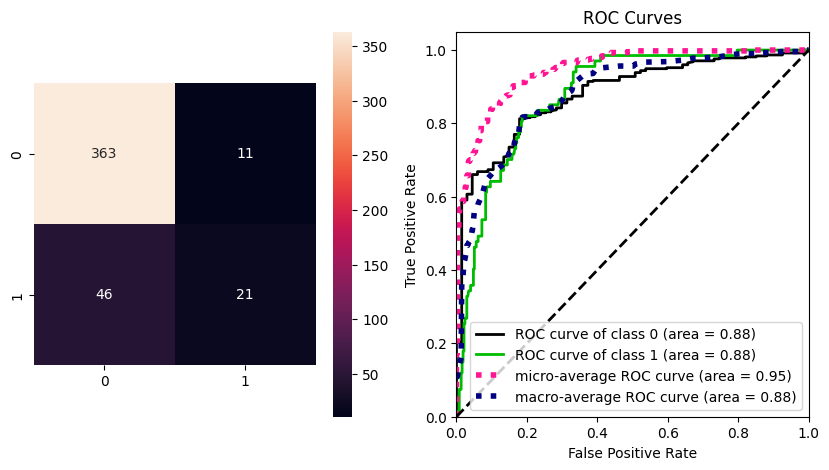

In [158]:
y_pred_X_test = rfc_model.predict(X_test)

print('Accuracy:', round(accuracy_score(y_test, y_pred_X_test)*100, 2), '%')
print('\nClassification Report:\n', classification_report(y_test, y_pred_X_test))

# Plots
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_X_test), annot=True, fmt='g', square=True, ax=axs[0])

# ROC
skplt.metrics.plot_roc(y_test, rfc_model.predict_proba(X_test), ax=axs[1]);

Plotting the true positive rate vs. false positive rate - i.e. the Receiver Operating Characteristic (ROC) Curve - suggests that the model separates the classes to a great extend, with an AUC (Area Under the ROC Curve) of 0.88 indicating a 88% likelihood of correcly classifying a case. 

Overall, the model's performance seems good. The accuracy score of 87% is great, with a recall of class 0 being 97%. However, the prediction of class 1 only provides 31% success. With class imbalance being present in our data (only around 15% of our sample responded to the campaign), the accuracy score is arguably biased. Paying closer attentiont to the precision score for class 1 (0.66), as well as the recall (abovementioned 31%) and F1-score (0.42), we will have to conlcude a rather mediocre performance of our model.

### Feature Importance (based on mean decrease in impurity)

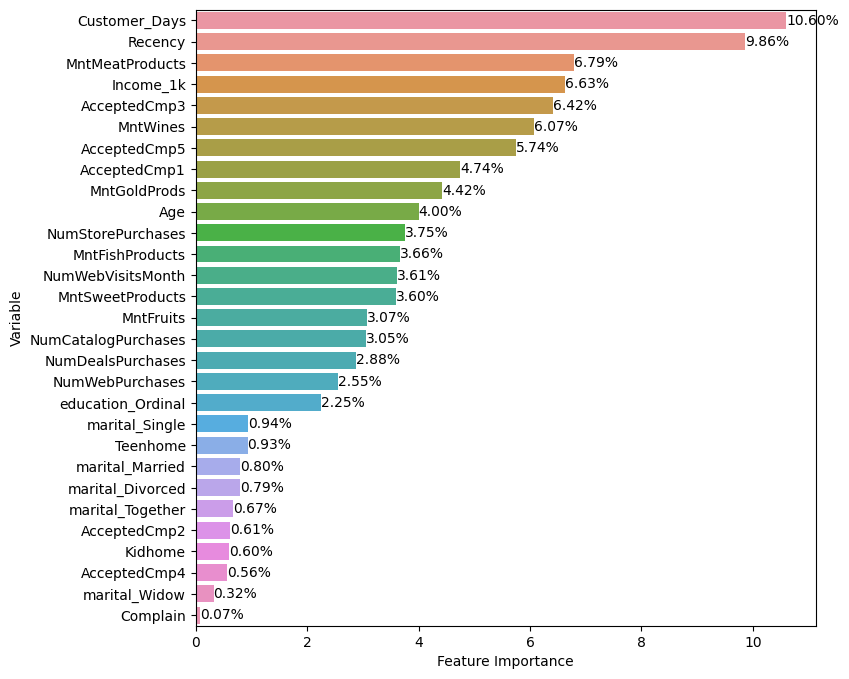

In [161]:
rfc_imp = pd.DataFrame({
    'Variable': X_rf.columns.to_list(),
    'Feature Importance': np.round(rfc.feature_importances_ * 100, 2)
})

rfc_imp.sort_values('Feature Importance', ascending=False, inplace=True)

plt.figure(figsize=(8,8))
ax = sns.barplot(data=rfc_imp, y='Variable', x='Feature Importance')
ax.bar_label(ax.containers[0], fmt='%.2f%%');

The 2 most important features for predicting whether someones response to the offer of the last campaign are the number of days someone has been a customer to the company, and the number of days since their last purchase.

Furthermore, ones income as well as the amount spent on the product categories meat, wine, and gold also show considerable high importance.

Finally, responses to preceeding campaigns (more specifically: 3, 5, and 1) are also amongst the most important features.